In [1]:
import numpy as np
import pandas as pd
import sys
import time
import datetime
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy
from obspy.signal.trigger import coincidence_trigger
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()

In [2]:
# Define networks, stations, channels, and year
# stations as string 'network-station-channel'
s1  = 'UW-EDM-EHZ'
s2  = 'UW-SHW-EHZ'
s3  = 'UW-HSR-EHZ'
s4  = 'UW-SOS-EHZ'
s5  = 'UW-JUN-EHZ'
s6  = 'UW-ELK-EHZ'
s7  = 'UW-TDL-EHZ'
s8  = 'UW-SUG-EHZ'
s9  = 'UW-YEL-EHZ'
s10 = 'UW-FL2-EHZ'
s11 = 'UW-CDF-EHZ'
s12 = 'UW-SEP-EHZ' # is not runnign for the whole two month
s13 = 'UW-STD-EHZ'


list_stations = [s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s13]# make a list of all stations
year = 2004
jdays = range(245, 306+1)

# Define the threshold parameters for triggering
short_win = 0.5 # short time window in seconds
long_win = 30 # long time window in seconds

trig_on = 5.5 # trigger turns on
trig_off = 1. # trigger turns off

# Create an empty list to store triggers
trigger_list = []

# Start timer
start_time = time.time()

# Loop through Julian days from 245 to 306
for i,doy in enumerate(jdays):
    
    stream = obspy.Stream()
    
    # Loop through each network, station, and channel
    for netstacha in list_stations:
        net = netstacha.split('-')[0]
        sta = netstacha.split('-')[1]
        cha = netstacha.split('-')[2]

        # Get waveforms for each day
        st = client.get_waveforms(network=net, station=sta, channel=cha, year=year, doy=doy)
        st.merge(fill_value=0)
        stream += st

#     trig = coincidence_trigger("classicstalta", trig_on, trig_off, stream, len(list_stations)*0.5, 
#                                sta=st, lta=lt)
    
    trig = coincidence_trigger("classicstalta", trig_on, trig_off, stream, len(list_stations)*0.5, 
                               sta=short_win, lta=long_win)
        
    trigger_list.append(trig)
    
    sys.stdout.write(f'\r{i} of {len(jdays)}')
#     sys.stdout.write(f'\rRunning since {round(time.time()-start_time)} seconds')
    sys.stdout.flush()
    
print(f'\nTotal running time: {round(time.time()-start_time)} seconds')
    

2 of 62

KeyboardInterrupt: 

In [ ]:
trigger_flat_list = [item for sublist in trigger_list for item in sublist]
UTC_list = []
for i in range(len(trigger_flat_list)):
    UTC_list.append(trigger_flat_list[i]['time'])
UTC_list


In [150]:
df = pd.DataFrame(index=UTC_list, columns=['count'], data=np.ones(len(UTC_list)))
df.index = [timestamp.datetime for timestamp in UTC_list] # Convert index to datetime
df.index.name = 'UTC'
df = df.resample('10min').sum()

df.to_csv(f'./StaLta/StaLta_win_{short_win}_{long_win}_trig_{trig_on}_{trig_off}.csv')


In [2]:
# Define the threshold parameters for triggering
short_win = 0.5 # short time window in seconds
long_win = 30 # long time window in seconds

trig_on = 5.5 # trigger turns on
trig_off = 1. # trigger turns off
# trig_off = 1. # trigger turns off

df = pd.read_csv(f'./StaLta/StaLta_win_{short_win}_{long_win}_trig_{trig_on}_{trig_off}.csv',
                 index_col='UTC', parse_dates=True)
df

,count
UTC,
2004-09-01 07:20:00,1.0
2004-09-01 07:30:00,0.0
2004-09-01 07:40:00,0.0
2004-09-01 07:50:00,0.0
2004-09-01 08:00:00,0.0
...,...
2004-11-01 23:10:00,4.0
2004-11-01 23:20:00,5.0
2004-11-01 23:30:00,13.0


In [3]:
df = df.rolling('1H', center=True).mean()

(12662.0, 12723.0)

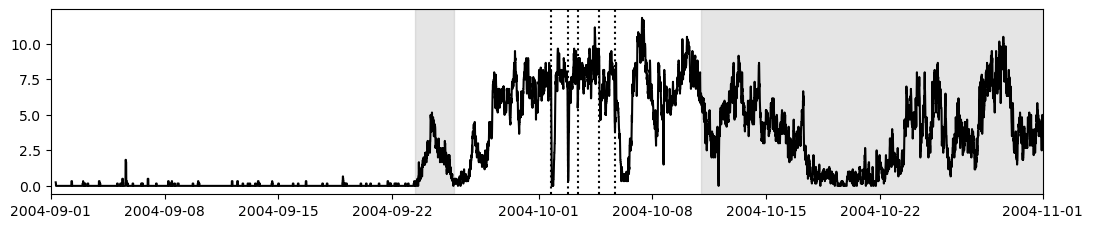

In [4]:
fig, ax = plt.subplots(1,1,figsize=(6.4*2, 4.8*0.5))
ax.plot(df,color='k')

sdates = [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,11)]
edates = [datetime.datetime(2004,9,25,19,0),datetime.datetime(2008,2,1)]

for (sdate,edate) in zip(sdates,edates):
    ax.axvspan(sdate, edate, alpha=0.2, color='gray')

    
for i in [datetime.datetime(2004,10,1,19,2),
          datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),
          datetime.datetime(2004,10,4,16,43),
          datetime.datetime(2004,10,5,16,5)]:
    ax.axvline(i, color='k',linestyle=':')

ax.set_xlim(datetime.datetime(2004,9,1),datetime.datetime(2004,11,1))
# plt.savefig(f'./StaLta/StaLta_win_{short_win}_{long_win}_trig_{trig_on}_{trig_off}.png', dpi=300, bbox_inches='tight')

## Compare to PNSN catalog

In [5]:
df_pnsn = pd.read_csv("/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity/pnsn_catalog_mtsthelens_50km.csv")
df_pnsn = df_pnsn.drop(['Unnamed: 0'], axis=1)
df_pnsn = df_pnsn.set_index('Date')
df_pnsn.index = pd.to_datetime(df_pnsn.index)
df_pnsn = df_pnsn.sort_index()
df_pnsn.head()

,Number_of_Events
Date,
1980-01-07,1
1980-01-08,1
1980-01-25,1
1980-01-27,1
1980-02-09,1


In [6]:
# load data
df_pnsn = pd.read_csv("/home/koepflma/project1/Mt-St-Helens/MtStHelens_activity/pnsn_catalog_mtsthelens_50km_utc.csv")
df_pnsn['UTC'] = [UTCDateTime(i) for i in df_pnsn['timestamp']] # timestamp to obspy.UTCDateTime
df_pnsn['event'] = 1 # add new row with ones
df_pnsn = df_pnsn.set_index('UTC') # set obspy.UTCDateTime to index
df_pnsn = df_pnsn.sort_index() # sort index
df_pnsn.head()

,source_id,timestamp,event_type,year,month,day,doy,hour,minute,second,microsecond,latitude,longitude,depth,magnitude,magnitude_type,contributor,number_of_pick,dist,event
UTC,,,,,,,,,,,,,,,,,,,,
1980-01-07T17:52:25.170000Z,uw10074693,3.161155e+08,earthquake,1980,1,7,7,17,52,25,170000,46.455,-122.415,11.935,1.0,md,uw,10,37.880,1
1980-01-08T19:22:53.020000Z,uw10074723,3.162074e+08,earthquake,1980,1,8,8,19,22,53,20000,46.642,-122.271,14.953,1.5,md,uw,16,49.963,1
1980-01-25T22:44:40.520000Z,uw10074988,3.176883e+08,earthquake,1980,1,25,25,22,44,40,520000,46.572,-122.195,-1.315,0.8,md,uw,7,41.338,1
1980-01-27T05:20:19.460000Z,uw10075003,3.177984e+08,earthquake,1980,1,27,27,5,20,19,460000,46.283,-122.487,9.530,1.6,md,uw,11,34.418,1
1980-02-09T00:28:56.830000Z,uw10075403,3.189041e+08,earthquake,1980,2,9,40,0,28,56,830000,46.179,-122.174,-1.084,3.2,md,uw,18,2.904,1


In [7]:
# create a new df, only times of interest
st = UTCDateTime(year=2004, month=1, day=1)
et = UTCDateTime(year=2008, month=12, day=31)
df_cut = df_pnsn[(df_pnsn.index >= st) & (df_pnsn.index <= et)]
df_cut.index = [i.datetime for i in df_cut.index] # index to datetime
df_cut

,source_id,timestamp,event_type,year,month,day,doy,hour,minute,second,microsecond,latitude,longitude,depth,magnitude,magnitude_type,contributor,number_of_pick,dist,event
2004-01-12 23:00:04.250,uw10599383,1.073948e+09,earthquake,2004,1,12,12,23,0,4,250000,46.318,-122.239,7.648,0.9,md,uw,18,14.216,1
2004-01-14 00:08:23.830,uw10599948,1.074039e+09,earthquake,2004,1,14,14,0,8,23,830000,46.200,-122.187,0.106,0.5,md,uw,13,0.211,1
2004-01-14 14:14:44.480,uw10600088,1.074090e+09,earthquake,2004,1,14,14,14,14,44,480000,46.025,-122.477,15.319,0.2,md,uw,8,37.534,1
2004-01-14 15:52:54.490,uw10600103,1.074096e+09,earthquake,2004,1,14,14,15,52,54,490000,46.210,-122.297,5.732,0.1,md,uw,11,12.079,1
2004-01-21 17:35:20.750,uw10602128,1.074707e+09,earthquake,2004,1,21,21,17,35,20,750000,46.482,-122.369,17.844,0.6,md,uw,13,37.184,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-24 13:30:54.370,uw10761273,1.230125e+09,earthquake,2008,12,24,359,13,30,54,370000,46.342,-122.204,8.951,0.7,md,uw,8,15.835,1
2008-12-24 23:31:47.430,uw10761283,1.230162e+09,earthquake,2008,12,24,359,23,31,47,430000,46.090,-122.514,12.600,0.6,md,uw,9,38.205,1
2008-12-27 15:59:14.740,uw10761933,1.230394e+09,earthquake,2008,12,27,362,15,59,14,740000,46.361,-122.305,17.535,1.0,md,uw,26,22.044,1
2008-12-29 17:27:49.770,uw10762713,1.230572e+09,earthquake,2008,12,29,364,17,27,49,770000,46.313,-122.236,7.699,0.6,md,uw,9,13.574,1


In [8]:
df_res = df_cut.resample('10min').sum()
df_roll = df_res.rolling('1H', center=True).mean()
# df_roll = df_cut.rolling('10min', center=True).sum()
df_res

/tmp/ipykernel_2929880/152867150.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_res = df_cut.resample('10min').sum()


,timestamp,year,month,day,doy,hour,minute,second,microsecond,latitude,longitude,depth,magnitude,number_of_pick,dist,event
2004-01-12 23:00:00,1.073948e+09,2004,1,12,12,23,0,4,250000,46.318,-122.239,7.648,0.9,18,14.216,1
2004-01-12 23:10:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2004-01-12 23:20:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2004-01-12 23:30:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2004-01-12 23:40:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-12-29 22:20:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2008-12-29 22:30:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2008-12-29 22:40:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0
2008-12-29 22:50:00,0.000000e+00,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.0,0,0.000,0


(12662.0, 12723.0)

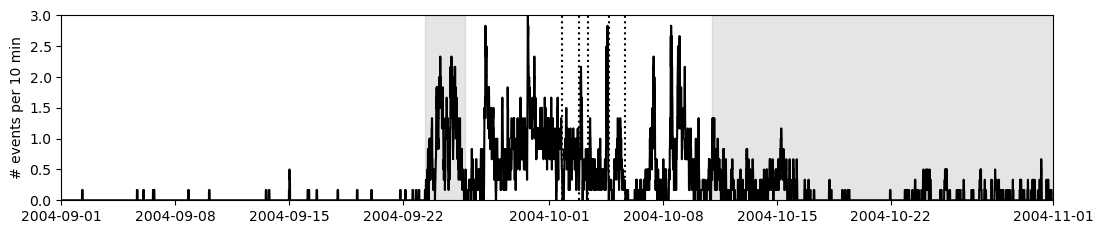

In [9]:
# plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(6.4*2,4.8*0.5))
ax.plot(df_roll.index,df_roll.event, color='k')
# plt.plot(df_res.index,df_res.event, alpha=0.8)
ax.set_xlim(UTCDateTime(2004,9,1), UTCDateTime(2004,11,1))
ax.set_ylim(0,3)
ax.set_ylabel('# events per 10 min')

sdates = [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,11)]
edates = [datetime.datetime(2004,9,25,19,0),datetime.datetime(2008,2,1)]

for (sdate,edate) in zip(sdates,edates):
    ax.axvspan(sdate, edate, alpha=0.2, color='gray')

    
for i in [datetime.datetime(2004,10,1,19,2),
          datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),
          datetime.datetime(2004,10,4,16,43),
          datetime.datetime(2004,10,5,16,5)]:
    ax.axvline(i, color='k',linestyle=':')

ax.set_xlim(datetime.datetime(2004,9,1),datetime.datetime(2004,11,1))

# plt.savefig('pnsn_catalog_res10min_sum_roll1h_mean3.png', dpi=300, bbox_inches='tight')

# Pair the two plots

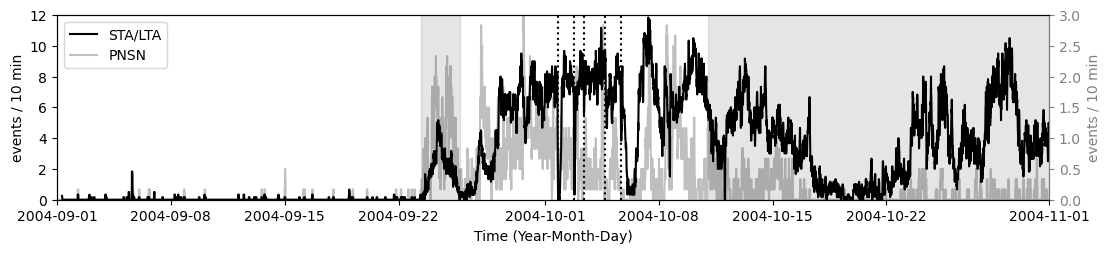

In [11]:
fig, ax = plt.subplots(1,1,figsize=(6.4*2, 4.8*0.5))
ax.plot(df,color='k', label='STA/LTA')
ax.plot(np.nan, color='k', alpha=0.25, label='PNSN')

ax0 = ax.twinx()

ax0.plot(df_roll.index,df_roll.event, color='k', alpha=0.25)

sdates = [datetime.datetime(2004,9,23,9,0),datetime.datetime(2004,10,11)]
edates = [datetime.datetime(2004,9,25,19,0),datetime.datetime(2008,2,1)]

for (sdate,edate) in zip(sdates,edates):
    ax.axvspan(sdate, edate, alpha=0.2, color='gray')

    
for i in [datetime.datetime(2004,10,1,19,2),
          datetime.datetime(2004,10,2,19,15),
          datetime.datetime(2004,10,3,9,50),
          datetime.datetime(2004,10,4,16,43),
          datetime.datetime(2004,10,5,16,5)]:
    ax.axvline(i, color='k',linestyle=':')

ax.set_xlim(datetime.datetime(2004,9,1),datetime.datetime(2004,11,1))
ax.set_xlabel('Time (Year-Month-Day)')
ax.set_ylim(0,12)
ax0.set_ylim(0,3)
ax.set_ylabel('events / 10 min')
ax0.set_ylabel('events / 10 min', color='gray')
# color ticks and spines
ax0.spines['right'].set_color('gray')
ax0.tick_params(axis='y', colors='gray')
ax.legend(loc='upper left')
# plt.savefig(f'./StaLta/PNSN_StaLta_win_{short_win}_{long_win}_trig_{trig_on}_{trig_off}.png', dpi=300, bbox_inches='tight')
